# Tracing Basics

setting up environment variables:

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

## How to add Tracing?
We'll use  @traceable
Decorating any function with @traceable enables it to be traced, the decorator creates a run tree in the backend every time these funcs are called. The information is then streamed into LangSmith.



In [ ]:
# importing traceable
from langsmith import traceable
from openai import OpenAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "openai"
MODEL_NAME = "gpt-4o-mini"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are now an assistant for simple question-answering tasks. 
Follow the following rules to answer the given question in the conversation. 
If you don't know the answer, just say that you don't know. If you are unsure about the answer, add it to the end of your answers that you're unsure
Use three sentences maximum and keep the answer concise.
"""

openai_client = OpenAI()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

# setting up tracable for every function
@traceable
def retrieve_documents(question: str):
    return retriever.invoke(question)   # NOTE: This is a LangChain vector db retriever, so this .invoke() call will be traced automatically

@traceable
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_openai(messages)

@traceable
def call_openai(
    messages: List[dict], model: str = MODEL_NAME, temperature: float = 0.0
) -> str:
    return openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )

@traceable
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content

In [18]:
question = "Hey this is Viraja, how exactly does @traceable maintain its runs and traces systematically"
ai_answer = langsmith_rag(question)
print(ai_answer)

The `@traceable` decorator in LangChain systematically maintains runs and traces by recording each step of the application's execution, from input to output. It creates a trace that groups multiple runs, where each run represents a specific operation or unit of work within the application. This structured logging allows for detailed observability and evaluation of the application's performance and behavior.


## Adding Metadata:
### (to help send more info along w the trace)
Metadata is a collection of key-value pairs that can be attached to runs. Metadata can be used to store additional information about a run, such as the version of the application that generated the run, the environment in which the run was generated, or any other information that you want to associate with a run. Similar to tags, you can use metadata to filter runs in the LangSmith UI, and can be used to group runs together for analysis.

In [11]:
from langsmith import traceable

@traceable(
        metadata={"vectordb" : "sklearn"}
)
def retrieve_documents(question: str):
    return retriever.invoke(question)

@traceable
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_openai(messages)

@traceable(
        metadata={"model__name" : MODEL_NAME, "model__provider":MODEL_PROVIDER}
)
def call_openai(
    messages: List[dict], model: str = MODEL_NAME, temperature: float = 0.0
) -> str:
    return openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )

@traceable
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content

In [10]:
question = "This is Viraja again, how does Metadata even help towards @traceable?"
ai_answer = langsmith_rag(question)
print(ai_answer)

Metadata helps organize and filter traces in LangSmith by storing additional key-value information about each trace, such as environment details or user info. It allows users to search and categorize traces more efficiently within the dashboard. Overall, metadata enhances trace management and analysis.


In [20]:
question = "How to add metadata at runtime and how is it different?"
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"runtime_metadata":"newdata"}})
print(ai_answer)

To add metadata at runtime, you can attach it when running an experiment in the SDK, which helps in filtering experiments later in the UI. This metadata can include details like the model used or specific identifiers for prompts. The key difference is that metadata added at runtime is not automatically propagated between parent and child runs, so each run must have its own metadata attached for effective filtering and analysis.


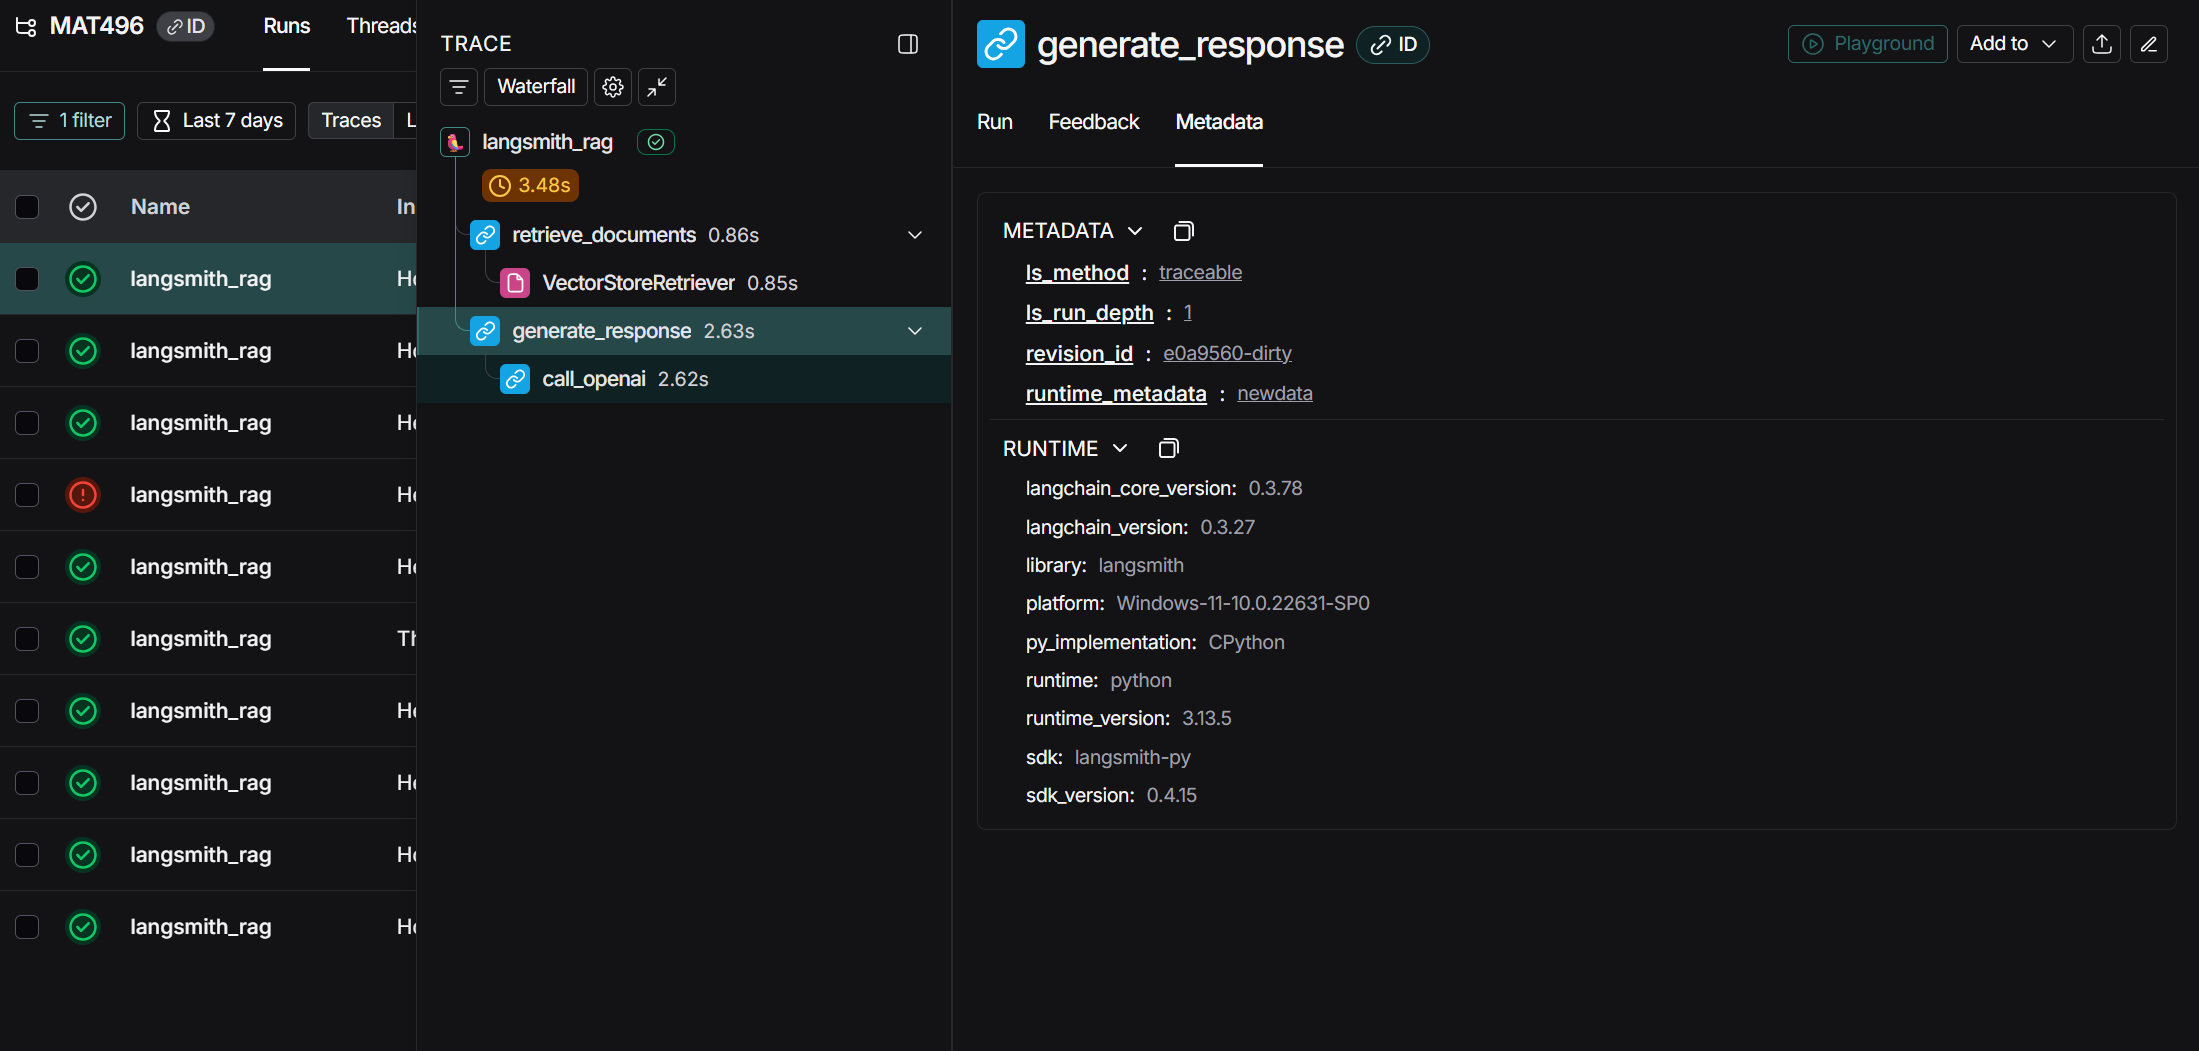